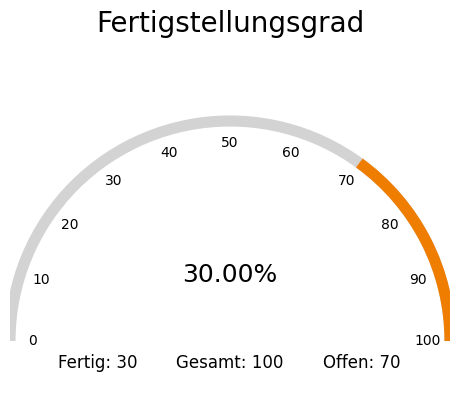

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import numpy as np

# Daten definieren
open_ALL = 70
done_All = 30
sum_picks = open_ALL + done_All
completion_rate = round((done_All / sum_picks) * 100, 2)

# Farbeinstellungen
if completion_rate < 25:
    bar_color = '#e72582'
elif 25 <= completion_rate < 50:
    bar_color = '#ef7d00'
elif 50 <= completion_rate < 75:
    bar_color = '#ef7d00'
else:
    bar_color = 'green'

# Grundlinie des Tachometers
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlim(0, 100)
ax.set_ylim(-10, 60)  # Veränderte y-Achse, um mehr Raum zu schaffen

# Grundbogen des Tachometers
arc = Arc([50, 0], 100, 100, angle=0, theta1=0, theta2=180, color='lightgrey', lw=8)
ax.add_patch(arc)

# Fortschrittsbogen
arc2 = Arc([50, 0], 100, 100, angle=0, theta1=0, theta2=180 * completion_rate / 100, color=bar_color, lw=8)
ax.add_patch(arc2)

# Werte auf dem Tachometer korrekt positionieren, die tatsächlichen Anteile von sum_picks anzeigen
scale_factor = sum_picks / 100  # Faktor, um die tatsächlichen Werte basierend auf dem maximalen Wert sum_picks zu berechnen
for i in range(0, 101, 10):
    angle = np.radians(180 - i * 180 / 100)  # Winkel von oben beginnend, gegen den Uhrzeigersinn
    x = 50 + 45 * np.cos(angle)
    y = 45 * np.sin(angle)
    value = int(scale_factor * i)  # Skalierte Werte von 0 bis sum_picks
    ax.text(x, y, str(value), horizontalalignment='center', verticalalignment='center', color='black')

# Setze Überschrift höher
plt.title('Fertigstellungsgrad', fontsize=20,verticalalignment='bottom', y=1.1)

# Zentrale Werte und Text
plt.text(50, 15, f'{completion_rate:.2f}%', ha='center', va='center', fontsize=18, color='black')
plt.text(50, -5, f'Gesamt: {sum_picks}', ha='center', va='center', fontsize=12, color='black')
plt.text(20, -5, f'Fertig: {done_All}', ha='center', va='center', fontsize=12, color='black')
plt.text(80, -5, f'Offen: {open_ALL}', ha='center', va='center', fontsize=12, color='black')

# Achsen und Raster ausblenden
ax.set_aspect('equal')
ax.axis('off')

plt.show()


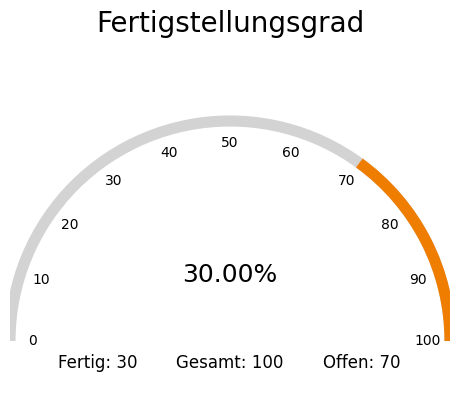

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import numpy as np

# Daten definieren
open_ALL = 70
done_All = 30
sum_picks = open_ALL + done_All
completion_rate = round((done_All / sum_picks) * 100, 2)

# Farbeinstellungen
if completion_rate < 25:
    bar_color = '#e72582'
elif 25 <= completion_rate < 50:
    bar_color = '#ef7d00'
elif 50 <= completion_rate < 75:
    bar_color = '#ef7d00'
else:
    bar_color = 'green'

# Grundlinie des Tachometers
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlim(0, 100)
ax.set_ylim(-10, 60)  # Veränderte y-Achse, um mehr Raum zu schaffen

# Grundbogen des Tachometers
arc = Arc([50, 0], 100, 100, angle=0, theta1=0, theta2=180, color='lightgrey', lw=8)
ax.add_patch(arc)

# Fortschrittsbogen
arc2 = Arc([50, 0], 100, 100, angle=0, theta1=0, theta2=180 * completion_rate / 100, color=bar_color, lw=8)
ax.add_patch(arc2)

# Werte auf dem Tachometer korrekt positionieren, die tatsächlichen Anteile von sum_picks anzeigen
for i in range(0, 101, 10):
    angle = np.radians(180 - i * 180 / 100)  # Winkel von oben beginnend, gegen den Uhrzeigersinn
    x = 50 + 45 * np.cos(angle)
    y = 45 * np.sin(angle)
    value = int(sum_picks * i / 100)  # Berechnet den tatsächlichen Wert für den Prozentanteil
    ax.text(x, y, str(value), horizontalalignment='center', verticalalignment='center', color='black')

# Setze Überschrift höher
plt.title('Fertigstellungsgrad', fontsize=20, verticalalignment='bottom', y=1.1)

# Zentrale Werte und Text
plt.text(50, 15, f'{completion_rate:.2f}%', ha='center', va='center', fontsize=18, color='black')
plt.text(50, -5, f'Gesamt: {sum_picks}', ha='center', va='center', fontsize=12, color='black')
plt.text(20, -5, f'Fertig: {done_All}', ha='center', va='center', fontsize=12, color='black')
plt.text(80, -5, f'Offen: {open_ALL}', ha='center', va='center', fontsize=12, color='black')

# Achsen und Raster ausblenden
ax.set_aspect('equal')
ax.axis('off')

plt.show()


Text(0.5, 1.1, 'Fertigstellungsgrad')

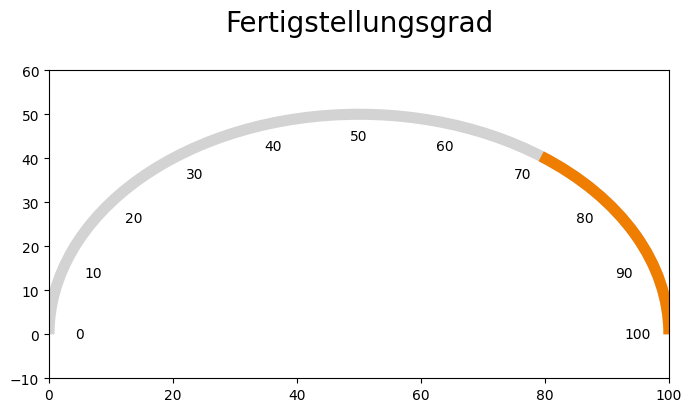

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import numpy as np

# Daten definieren
open_ALL = 70
done_All = 30
sum_picks = open_ALL + done_All
completion_rate = round((done_All / sum_picks) * 100, 2)

# Farbeinstellungen
if completion_rate < 25:
    bar_color = '#e72582'
elif 25 <= completion_rate < 50:
    bar_color = '#ef7d00'
elif 50 <= completion_rate < 75:
    bar_color = '#ef7d00'
else:
    bar_color = 'green'

# Grundlinie des Tachometers
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlim(0, 100)
ax.set_ylim(-10, 60)  # Veränderte y-Achse, um mehr Raum zu schaffen

# Grundbogen des Tachometers
arc = Arc([50, 0], 100, 100, angle=0, theta1=0, theta2=180, color='lightgrey', lw=8)
ax.add_patch(arc)

# Fortschrittsbogen
arc2 = Arc([50, 0], 100, 100, angle=0, theta1=0, theta2=180 * completion_rate / 100, color=bar_color, lw=8)
ax.add_patch(arc2)

# Werte auf dem Tachometer korrekt positionieren, die tatsächlichen Anteile von sum_picks anzeigen
for i in range(0, 101, 10):
    angle = np.radians(180 - i * 180 / 100)  # Winkel von oben beginnend, gegen den Uhrzeigersinn
    x = 50 + 45 * np.cos(angle)
    y = 45 * np.sin(angle)
    value = int(sum_picks * i / 100)  # Berechnet den tatsächlichen Wert für den Prozentanteil
    ax.text(x, y, str(value), horizontalalignment='center', verticalalignment='center', color='black')

# Setze Überschrift höher
plt.title('Fertigstellungsgrad', fontsize=20, y=1.1)


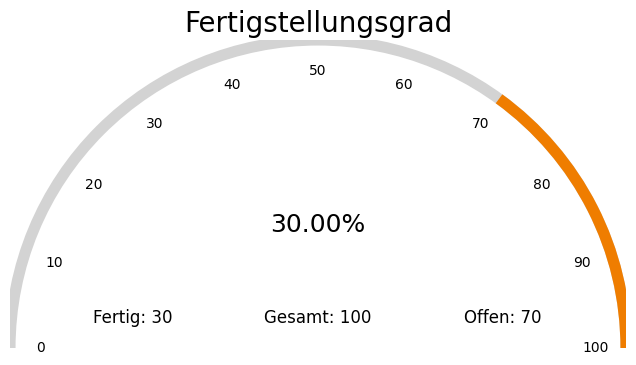

In [4]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import numpy as np

# Daten definieren
open_ALL = 70
done_All = 30
sum_picks = open_ALL + done_All
completion_rate = round((done_All / sum_picks) * 100, 2)

# Farbeinstellungen
if completion_rate < 25:
    bar_color = '#e72582'
elif 25 <= completion_rate < 50:
    bar_color = '#ef7d00'
elif 50 <= completion_rate < 75:
    bar_color = '#ef7d00'
else:
    bar_color = 'green'

# Grundlinie des Tachometers
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlim(0, 100)
ax.set_ylim(0, 50)

# Grundbogen des Tachometers
arc = Arc([50, 0], 100, 100, angle=0, theta1=0, theta2=180, color='lightgrey', lw=8)
ax.add_patch(arc)

# Fortschrittsbogen
arc2 = Arc([50, 0], 100, 100, angle=0, theta1=0, theta2=180 * completion_rate / 100, color=bar_color, lw=8)
ax.add_patch(arc2)

# Werte auf dem Tachometer korrekt positionieren
for i in range(0, 101, 10):
    angle = np.radians(180 - i * 180 / 100)  # Winkel von oben beginnend, gegen den Uhrzeigersinn
    x = 50 + 45 * np.cos(angle)
    y = 45 * np.sin(angle)
    ax.text(x, y, str(int(sum_picks * i / 100)), horizontalalignment='center', verticalalignment='center', color='black')
# Setze Überschrift
plt.title('Fertigstellungsgrad', fontsize=20)
# Zentrale Werte und Text
plt.text(50, 20, f'{completion_rate:.2f}%', ha='center', va='center', fontsize=18, color='black')
plt.text(50, 5, f'Gesamt: {sum_picks}', ha='center', va='center', fontsize=12, color='black')
plt.text(20, 5, f'Fertig: {done_All}', ha='center', va='center', fontsize=12, color='black')
plt.text(80, 5, f'Offen: {open_ALL}', ha='center', va='center', fontsize=12, color='black')

# Achsen und Raster ausblenden
ax.set_aspect('equal')
ax.axis('off')

plt.show()


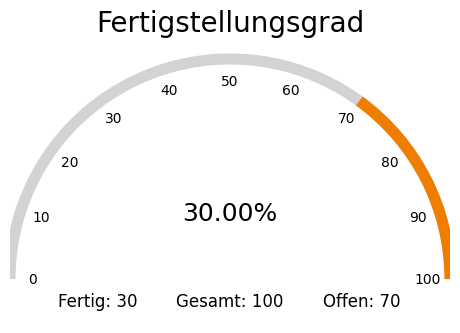

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import numpy as np

# Daten definieren
open_ALL = 70
done_All = 30
sum_picks = open_ALL + done_All
completion_rate = round((done_All / sum_picks) * 100, 2)

# Farbeinstellungen
if completion_rate < 25:
    bar_color = '#e72582'
elif 25 <= completion_rate < 50:
    bar_color = '#ef7d00'
elif 50 <= completion_rate < 75:
    bar_color = '#ef7d00'
else:
    bar_color = 'green'

# Grundlinie des Tachometers
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xlim(0, 100)
ax.set_ylim(-10, 60)  # Veränderte y-Achse, um mehr Raum zu schaffen

# Grundbogen des Tachometers
arc = Arc([50, 0], 100, 100, angle=0, theta1=0, theta2=180, color='lightgrey', lw=8)
ax.add_patch(arc)

# Fortschrittsbogen
arc2 = Arc([50, 0], 100, 100, angle=0, theta1=0, theta2=180 * completion_rate / 100, color=bar_color, lw=8)
ax.add_patch(arc2)

# Werte auf dem Tachometer korrekt positionieren, die tatsächlichen Anteile von sum_picks anzeigen
for i in range(0, 101, 10):
    angle = np.radians(180 - i * 180 / 100)  # Winkel von oben beginnend, gegen den Uhrzeigersinn
    x = 50 + 45 * np.cos(angle)
    y = 45 * np.sin(angle)
    value = int(sum_picks * i / 100)  # Berechnet den tatsächlichen Wert für den Prozentanteil
    ax.text(x, y, str(value), horizontalalignment='center', verticalalignment='center', color='black')

# Setze Überschrift höher
plt.title('Fertigstellungsgrad', fontsize=20, verticalalignment='bottom', y=0.9)

# Zentrale Werte und Text
plt.text(50, 15, f'{completion_rate:.2f}%', ha='center', va='center', fontsize=18, color='black')
plt.text(50, -5, f'Gesamt: {sum_picks}', ha='center', va='center', fontsize=12, color='black')
plt.text(20, -5, f'Fertig: {done_All}', ha='center', va='center', fontsize=12, color='black')
plt.text(80, -5, f'Offen: {open_ALL}', ha='center', va='center', fontsize=12, color='black')

# Achsen und Raster ausblenden
ax.set_aspect('equal')
ax.axis('off')

plt.show()


In [2]:
from Data_Class.MMSQL_connection import read_Table

df_outbound = read_Table('prod_Kundenbestellungen')

df_outbound

,SapOrderNumber,CreatedTimestamp,CreatedBy,UpdatedTimestamp,UpdatedBy,Status,NiceLabelTransmissionState_Status,NiceLabelTransmissionState_TimeStamp,DeliveryDepot,IsReturnDelivery,...,PicksFertig,PicksOffen,Picks Karton offen,Picks Paletten offen,Picks Stangen offen,Picks Karton fertig,Picks Paletten fertig,Picks Stangen fertig,Fertiggestellt,First_Picking
0,3202443502,2023-06-13 12:55:10.634036+00:00,Service,2023-06-14 09:14:09.025338+00:00,02da76fe-9ee1-48ce-9a55-7c904dc15f1d,SSCCInformationSent,1,2023-06-13 12:55:10.634035+00:00,KNSTR,False,...,nan,nan,nan,nan,nan,36.0,0.0,25.0,2023-06-14 07:52:24.025495+00:00,2023-06-14 07:53:18.470601+00:00
1,3202443503,2023-06-13 12:54:15.934053+00:00,Service,2023-06-14 07:46:34.994645+00:00,02da76fe-9ee1-48ce-9a55-7c904dc15f1d,SSCCInformationSent,1,2023-06-13 12:54:15.934052+00:00,KNLEJ,False,...,nan,nan,nan,nan,nan,55.0,1.0,14.0,2023-06-14 06:04:30.421483+00:00,2023-06-14 06:04:58.706744+00:00
2,3202443504,2023-06-13 12:54:01.499934+00:00,Service,2023-06-14 05:23:36.560498+00:00,02da76fe-9ee1-48ce-9a55-7c904dc15f1d,SSCCInformationSent,1,2023-06-13 12:54:01.499932+00:00,KNLEJ,False,...,nan,nan,nan,nan,nan,3.0,0.0,95.0,2023-06-13 17:30:41.405230+00:00,2023-06-13 17:30:47.282568+00:00
3,3202443505,2023-06-13 12:54:08.017301+00:00,Service,2023-06-14 05:20:40.680937+00:00,02da76fe-9ee1-48ce-9a55-7c904dc15f1d,SSCCInformationSent,1,2023-06-13 12:54:08.017299+00:00,KNSTR,False,...,nan,nan,nan,nan,nan,0.0,0.0,77.0,2023-06-13 17:39:52.564667+00:00,2023-06-13 17:43:14.087427+00:00
4,3202443506,2023-06-13 12:54:40.734325+00:00,Service,2023-06-14 10:51:58.219780+00:00,02da76fe-9ee1-48ce-9a55-7c904dc15f1d,SSCCInformationSent,1,2023-06-13 12:54:40.734323+00:00,KNSTR,False,...,nan,nan,nan,nan,nan,11.0,0.0,7.0,2023-06-14 10:24:54.287715+00:00,2023-06-14 10:28:04.904013+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27518,3202443497,2023-06-13 12:53:47.252801+00:00,Service,2023-06-14 07:49:36.415829+00:00,02da76fe-9ee1-48ce-9a55-7c904dc15f1d,SSCCInformationSent,1,2023-06-13 12:53:47.252800+00:00,KNSTR,False,...,nan,nan,nan,nan,nan,20.0,0.0,0.0,2023-06-14 06:37:30.950556+00:00,2023-06-14 06:37:36.460414+00:00
27519,3202443498,2023-06-13 12:53:27.383813+00:00,Service,2023-06-14 07:48:31.246291+00:00,02da76fe-9ee1-48ce-9a55-7c904dc15f1d,SSCCInformationSent,1,2023-06-13 12:53:27.383795+00:00,KNSTR,False,...,nan,nan,nan,nan,nan,7.0,0.0,0.0,2023-06-14 06:21:17.507637+00:00,2023-06-14 06:21:50.383150+00:00
27520,3202443499,2023-06-13 12:53:31.559240+00:00,Service,2023-06-14 09:16:06.254377+00:00,02da76fe-9ee1-48ce-9a55-7c904dc15f1d,SSCCInformationSent,1,2023-06-13 12:53:31.559238+00:00,KNSTR,False,...,nan,nan,nan,nan,nan,30.0,0.0,0.0,2023-06-14 08:35:19.478480+00:00,2023-06-14 08:35:50.929927+00:00
27521,3202443500,2023-06-13 12:53:53.782186+00:00,Service,2023-06-14 05:40:25.235901+00:00,02da76fe-9ee1-48ce-9a55-7c904dc15f1d,SSCCInformationSent,1,2023-06-13 12:53:53.782184+00:00,KNLEJ,False,...,nan,nan,nan,nan,nan,21.0,0.0,32.0,2023-06-13 15:17:47.735837+00:00,2023-06-13 15:18:30.959072+00:00


In [1]:
import pandas as pd
import numpy as np
from Data_Class.MMSQL_connection import read_Table

df_outbound = read_Table('PAMS_SFG_SDDS_Outbound_Monitor')
df_outbound = df_outbound.dropna(subset=["Loading Date Plan DHL"])
df_outbound = df_outbound.dropna(subset=["Abholdatum Update"])
df_outbound = df_outbound.dropna(subset=["SCI"])
df_outbound = df_outbound[df_outbound["SCI"].str.isnumeric()]
df_outbound["Abholdatum Update"] = pd.to_datetime(df_outbound["Abholdatum Update"], errors='coerce')
df_outbound = df_outbound.rename(columns={"Abholdatum Update": "Pick-up date update"})
df_outbound["Loading Date Plan DHL"] = pd.to_datetime(df_outbound["Loading Date Plan DHL"], errors='coerce')
df_outbound["Difference in days"] = df_outbound["Pick-up date update"] - df_outbound["Loading Date Plan DHL"]
recent_data = df_outbound[df_outbound["Pick-up date update"] >= pd.Timestamp.now() - pd.Timedelta(days=20)]



data = recent_data.copy()

/var/folders/75/mgp5fc0n7t3dsv8hvb54xpy40000gn/T/ipykernel_23637/794480500.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  match_counts = data_clean.groupby('Pick-up date update').apply(


<Axes: xlabel='Pick-up date update'>

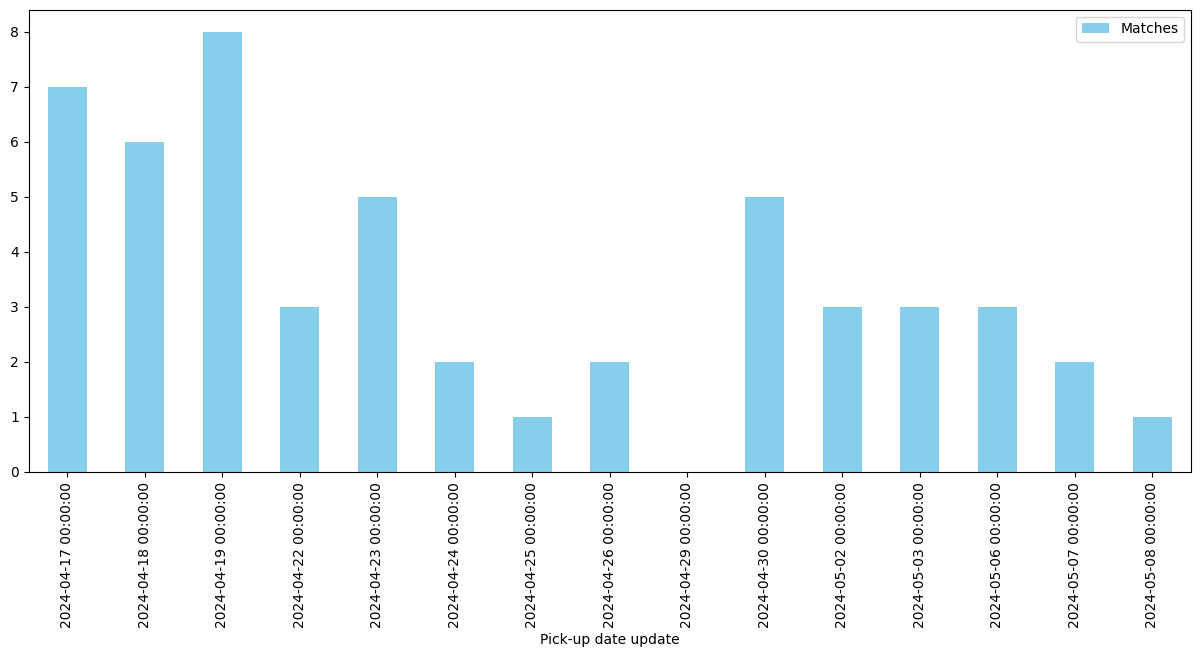

In [3]:
# Convert date columns to datetime format
data['Loading Date Plan DHL'] = pd.to_datetime(data['Loading Date Plan DHL'], errors='coerce')
data['Pick-up date update'] = pd.to_datetime(data['Pick-up date update'], errors='coerce')

# Drop rows where either date is NaT (not a time) to ensure accurate comparisons
data_clean = data.dropna(subset=['Loading Date Plan DHL', 'Pick-up date update'])

# Calculate match occurrences
match_counts = data_clean.groupby('Pick-up date update').apply(
    lambda x: (x['Loading Date Plan DHL'] == x['Pick-up date update']).sum()
).reset_index(name='Matches')

# Add total counts for better context
match_counts['Total Updates'] = data_clean.groupby('Pick-up date update').size().values

# Show results
match_counts.head(), match_counts.describe()

# show as bar chart
import matplotlib.pyplot as plt
match_counts.plot(x='Pick-up date update', y='Matches', kind='bar', figsize=(15, 6), color='skyblue')

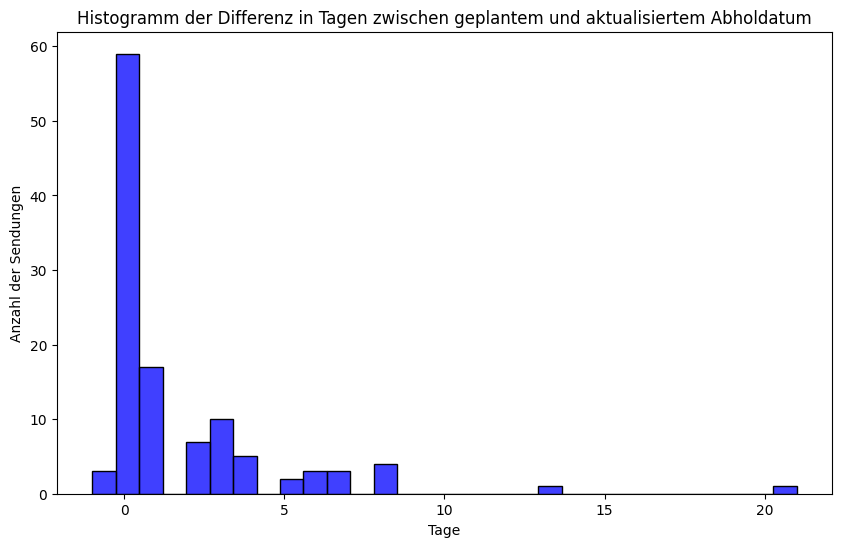

In [70]:


# Filter für die letzten 20 Tage
recent_data = df_outbound[df_outbound["Pick-up date update"] >= pd.Timestamp.now() - pd.Timedelta(days=20)]



/var/folders/75/mgp5fc0n7t3dsv8hvb54xpy40000gn/T/ipykernel_19349/444389651.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data['Days Difference'] = recent_data['Difference in days'].dt.days


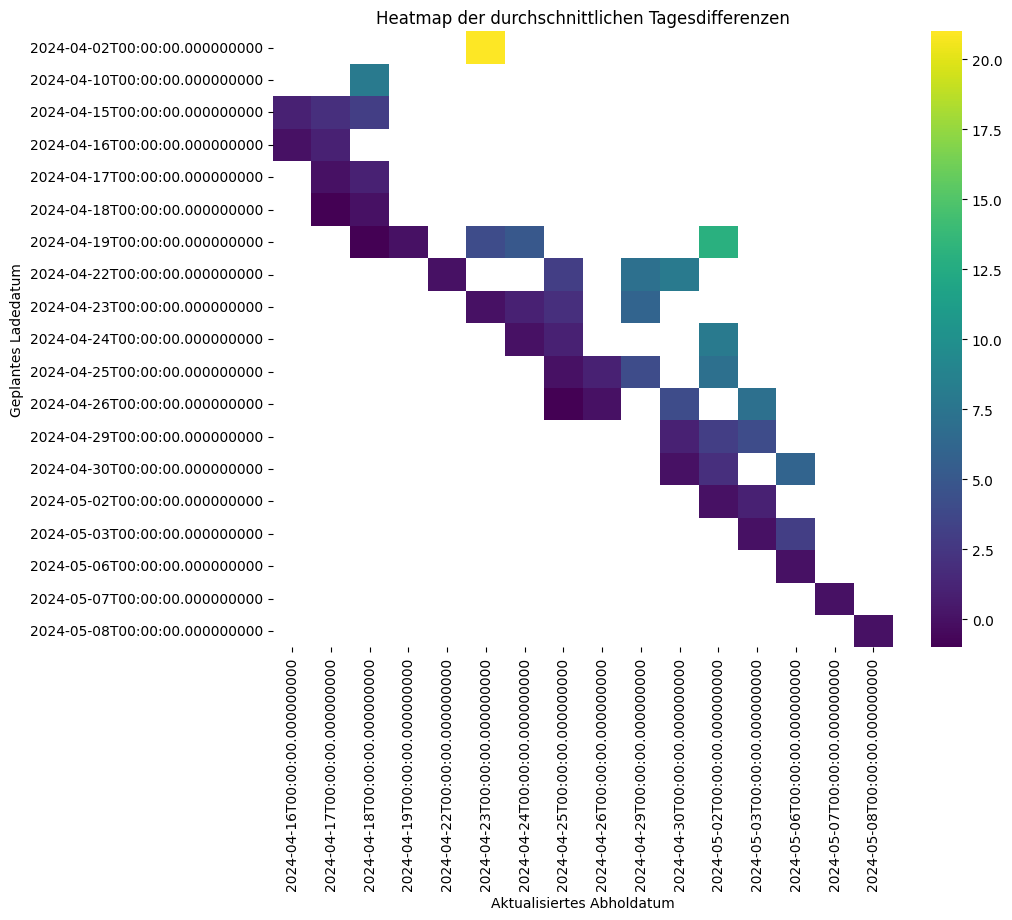

In [74]:
# Berechnung der Differenzen in ganzen Tagen
recent_data['Days Difference'] = recent_data['Difference in days'].dt.days

# Erstellung einer Pivot-Tabelle für die Heatmap
pivot_table = recent_data.pivot_table(index=pd.Grouper(key='Loading Date Plan DHL', freq='D'), columns=pd.Grouper(key='Pick-up date update', freq='D'), values='Days Difference', aggfunc='mean')

plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, cmap='viridis')
plt.title('Heatmap der durchschnittlichen Tagesdifferenzen')
plt.xlabel('Aktualisiertes Abholdatum')
plt.ylabel('Geplantes Ladedatum')
plt.show()


# Abweichung Ankunft zum Plandatum DIET Transporte

In [75]:
# import matplotlib.pyplot as plt

# # Konvertiere die Abweichungen in Tage
# df_outbound['Abweichung'] = df_outbound['Abweichung'].dt.days

# plt.hist(df_outbound['Abweichung'], bins=30, edgecolor='black')
# plt.title('Verteilung der Abweichungen')
# plt.xlabel('Abweichung (Tage)')
# plt.ylabel('Häufigkeit')
# plt.show()

In [76]:
import matplotlib.pyplot as plt

# Stelle sicher, dass das DataFrame sortiert ist
df_outbound = df_outbound.sort_values("Loading Date Plan DHL")

plt.figure(figsize=(10, 5))
plt.plot(df_outbound["Loading Date Plan DHL"], df_outbound["Abweichung"].dt.days, marker='o', linestyle='-')
plt.title('Zeitliche Entwicklung der Abweichungen')
plt.xlabel('Geplantes Ladedatum (DHL)')
plt.ylabel('Abweichung in Tagen')
plt.grid(True)
plt.show()


KeyError: 'Abweichung'

<Figure size 1000x500 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(df_outbound['Loading Date Plan DHL'], df_outbound['Abweichung'].dt.days, alpha=0.5)
plt.title('Scatter Plot der Abweichungen')
plt.xlabel('Geplantes Ladedatum (DHL)')
plt.ylabel('Abweichung in Tagen')
plt.grid(True)
plt.show()


KeyError: 'Abweichung'

<Figure size 1000x500 with 0 Axes>

In [ ]:
# Füge eine Spalte für das Jahr hinzu
df_outbound['Jahr'] = df_outbound['Loading Date Plan DHL'].dt.year

# Erstelle eine Pivot-Tabelle
pivot_table = df_outbound.pivot_table(values='Abweichung', index='Jahr', columns='Monat', aggfunc='mean', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table.dt.days, annot=True, cmap='coolwarm', fmt=".0f")
plt.title('Heatmap der durchschnittlichen täglichen Abweichungen')
plt.xlabel('Monat')
plt.ylabel('Jahr')
plt.show()


AttributeError: 'DataFrame' object has no attribute 'dt'

<Figure size 1200x800 with 0 Axes>